In [1]:
import sys
sys.path.append('./')
sys.path.append('./../../../../')
sys.path.append('./../../../../designer')
sys.path.append('./../../../../designer/script')

from spectrum import Spectrum
from film import MultiMaterialFilm, TwoMaterialFilm
from optimizer.adam import AdamThicknessOptimizer
from optimizer.archive.LM_gradient_descent import LM_optimize_d_simple
from design import BaseDesign

from utils.substitute import optimal_and_thin_film_approx_substitution_onestep_new, equal_optical_thickness_new, equal_optical_thickness
from utils.loss import calculate_RMS

import numpy as np
import matplotlib.pyplot as plt
import copy

In [8]:
wls = np.linspace(390, 710, 320)
wls_more = np.linspace(300, 800, 500)

target_spec_params = 20., wls
target = Spectrum(*target_spec_params, np.ones_like(wls))

reverse = lambda arr: np.ascontiguousarray(np.flip(arr))
d_init = reverse(np.loadtxt('./before')) # NOTE: the structures are in the reverse order
materials_init = reverse(np.loadtxt('./before_materials', dtype='str'))
d_eqot_benchmark = reverse(np.loadtxt('./after'))
materials_eqot_benchmark = reverse(np.loadtxt('./after_materials', dtype='str'))

print(materials_eqot_benchmark)
print(d_eqot_benchmark)

film_init = MultiMaterialFilm(materials_init, 'SiO2_exp', d_init)
# xc
film_eqot_benchmark = MultiMaterialFilm(materials_eqot_benchmark, 'SiO2_exp', d_eqot_benchmark)
# ours
film_eqot = copy.deepcopy(film_init)
film_optim = copy.deepcopy(film_init)


all_films = [film_init, film_eqot_benchmark, film_eqot, film_optim]
for film in all_films:
    film.add_spec_param(*target_spec_params)

['MgF2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc'
 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc']
[ 93.333 117.232  51.859   5.183 135.813  11.153 207.212  24.928  12.108
  90.294  31.529  15.26   97.318]


In [9]:
# w/o GD. NOTE: need to wait for compilation of CUDA at first run
d_min = 15.
equal_optical_thickness_new(film_eqot, d_min)
res = optimal_and_thin_film_approx_substitution_onestep_new(film_optim, d_min)
print(res)
print(calculate_RMS(film_optim, film_init))
print(calculate_RMS(film_eqot, film_init))

(4, [(1.006148136895876+0j), (1.1895149535237528+0j), (1.2169751821912633+0j), (1.192229563435345+0j)])
0.031029643906612128
0.033262233582526925


(0.9, 1.0)

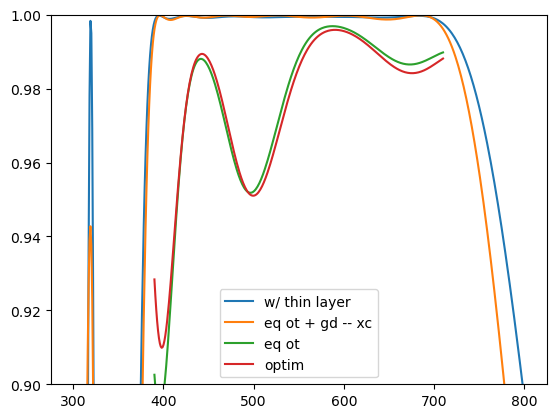

In [12]:
fig, ax = plt.subplots(1, 1)

ax.plot(wls_more, film_init.get_spec(20., wls_more).get_T(), label='w/ thin layer')
ax.plot(wls_more, film_eqot_benchmark.get_spec(20., wls_more).get_T(), label='eq ot + gd -- xc')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim')
ax.legend()
ax.set_ylim(0.9, 1)



This is weird. In our other experiments optim method seems to greatly outperform the equal ot...

Okay so i guess it is simply bad luck. Our strategy could not offer a result consistently outperforming eqot.

[ 58.07979026  73.81478226  32.09047389   2.           2.
   2.          15.55853105   2.           2.           2.
   2.          48.68332244  67.91440476   2.          70.6254902
   2.           2.          58.8854088    2.          44.5101197
   2.          72.31379183   2.           2.          57.4649018
   2.           2.           2.          41.79712576   2.
 100.59954225  70.23836759  93.28341085  87.57508713  40.79940413
   2.          68.34109025  58.78407624   2.          25.50545048]
[ 58.07979026  73.81478226  59.17233671  48.68332244 143.30156085
 186.39972713 206.00406864  70.23836759  93.28341085  87.57508713
 110.52132733  87.18632899]
optim sub res: (14, [(0.7260781845875236+0j), (0.7489415470444307+0j), (0.8138274779362661+0j), (0.8104041770307833+0j), (0.9687689616798031+0j), (0.7874720033449822+0j), (1.3306937520164024+0j), (1.32032900382667+0j), (1.1127226686722183+0j), (0.8781468458381115+0j), (0.8787094744262514+0j), (0.8337241212047565+0j), (0.9951564608126734

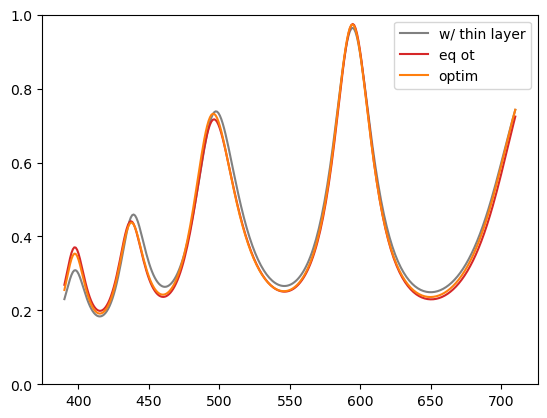

In [30]:
# toy scenario

d_min = 2
layer_number = 40
thin_number = 20

np.random.seed(3)
d_init = np.random.random(layer_number) * 100 + d_min + 1

thin_idx = np.arange(1, layer_number - 1)
np.random.shuffle(thin_idx)
thin_idx = thin_idx[:thin_number]

d_init[thin_idx] = d_min # artificial thin films
print(d_init)

film = TwoMaterialFilm('Ta2O5_xc', 'SiO2_xc', 'BK7', d_init)
film.add_spec_param(20., wls)

film_eqot = copy.deepcopy(film)
equal_optical_thickness_new(film_eqot, d_min + 1)
print(film_eqot.get_d())

film_optim = copy.deepcopy(film)
res = optimal_and_thin_film_approx_substitution_onestep_new(film_optim, d_min + 1)
print('optim sub res:', res)
fig, ax = plt.subplots(1, 1)

ax.plot(wls, film.get_spec().get_T(), label='w/ thin layer', c='grey')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot', c='C3')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim', c='C1')
ax.legend()
ax.set_ylim(0., 1)

print(calculate_RMS(film, film_optim))
print(calculate_RMS(film, film_eqot))